## Imports and downloads

In [1]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=7fb4a32b70786fea605b170006bd2c2285277c3bcd5f388773e60b5574634124
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
print('Imports done.')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpor

## Data pre-processing

In [3]:
electronics_dataset = pd.read_csv('../input/amazon-reviews-2018-electronics/labeled_electronics_dataset.csv')

electronics_dataset.head()

,overall,vote,reviewTime,reviewText,summary,Label
0,2,0,2010-02-10,Tech support is the worst,1265760000,NEGATIVE
1,2,0,2016-10-24,Screws were missing from the bracket and beaut...,Spend a little more and get much better.,NEGATIVE
2,1,0,2017-07-10,Trouble connecting and staying connected via b...,1499644800,NEGATIVE
3,4,5,2013-05-02,I purchased this unit for our RV to replace an...,Receiver Offers a Lot of Flexibility & Complexity,POSITIVE
4,3,0,2013-01-04,It works. Nuff said but the review requires 1...,It's a cable,NEUTRAL


In [4]:
# Check for NaN values
print("NaN (before cleanup) ?: \n", electronics_dataset.isnull().sum())

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].fillna('')

print("NaN (after cleanup) ?: \n", electronics_dataset.isnull().sum())

NaN (before cleanup) ?: 
 overall       0
vote          0
reviewTime    0
reviewText    1
summary       0
Label         0
dtype: int64
NaN (after cleanup) ?: 
 overall       0
vote          0
reviewTime    0
reviewText    0
summary       0
Label         0
dtype: int64


In [5]:
# Text preprocessing for reviewText column
# Lower all text

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].str.lower()

# Initialize pandarallel
# I used pandarallel because it applies the functions much faster than a normal pandas apply.
pandarallel.initialize(nb_workers=4,progress_bar=True)

# Remove all special characters
def remove_special_chars(text):
    return ''.join(x if x.isalnum() else ' ' for x in text)

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_special_chars)

# get stopwords.
stop_words = set(stopwords.words('english'))

# Remove stop_words
def remove_stopwords(text):
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]


electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_stopwords)

# Lemmatization
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(lemmatize_word)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_numbers)

print('Example of preprocessing train: ')
print(electronics_dataset['reviewText'][0])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Example of preprocessing train: 
tech support worst


## Model creation and evaluation

In [6]:
from sklearn.feature_extraction.text import HashingVectorizer

In [12]:
X = electronics_dataset['reviewText']
Y = electronics_dataset['Label']
vectorizer = HashingVectorizer(n_features=2**17)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print(X_train)

  (0, 26)	0.11867816581938533
  (0, 6035)	0.23735633163877065
  (0, 27487)	-0.11867816581938533
  (0, 32408)	-0.23735633163877065
  (0, 40054)	0.23735633163877065
  (0, 41987)	0.11867816581938533
  (0, 42930)	0.23735633163877065
  (0, 58327)	-0.11867816581938533
  (0, 58524)	0.11867816581938533
  (0, 60086)	-0.35603449745815596
  (0, 63383)	-0.11867816581938533
  (0, 63925)	0.23735633163877065
  (0, 65325)	0.11867816581938533
  (0, 76705)	-0.11867816581938533
  (0, 81460)	0.11867816581938533
  (0, 82575)	-0.23735633163877065
  (0, 90077)	0.11867816581938533
  (0, 92259)	0.23735633163877065
  (0, 107214)	0.35603449745815596
  (0, 113679)	-0.11867816581938533
  (0, 116871)	-0.11867816581938533
  (0, 120741)	0.11867816581938533
  (0, 121978)	0.11867816581938533
  (0, 123657)	-0.11867816581938533
  (0, 125697)	0.23735633163877065
  :	:
  (15846, 4193)	-0.1889822365046136
  (15846, 12734)	0.1889822365046136
  (15846, 33677)	0.1889822365046136
  (15846, 34775)	-0.1889822365046136
  (15846, 3

In [13]:
clf = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

In [14]:
y_pred = clf.predict(X_test)

print("predictions:\n", y_pred)

cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cnf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

predictions:
 ['NEGATIVE' 'POSITIVE' 'NEUTRAL' ... 'NEGATIVE' 'NEGATIVE' 'NEGATIVE']

Confusion Matrix:
 [[1246   76  253]
 [ 328  173  307]
 [ 247   84 1248]]

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.68      0.79      0.73      1575
     NEUTRAL       0.52      0.21      0.30       808
    POSITIVE       0.69      0.79      0.74      1579

    accuracy                           0.67      3962
   macro avg       0.63      0.60      0.59      3962
weighted avg       0.65      0.67      0.65      3962



<Axes: >

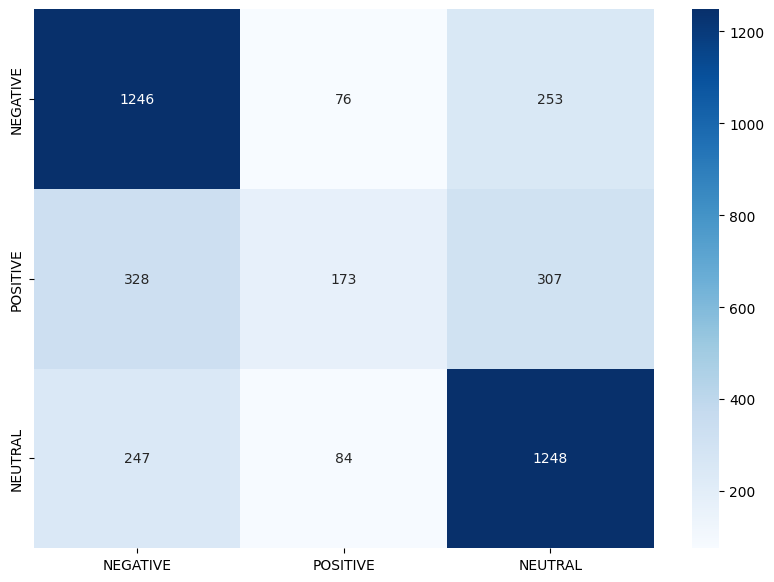

In [11]:
classes = electronics_dataset['Label'].unique()
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)